In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import datetime

np.random.seed(42)
tf.random.set_seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

2021-12-05 18:20:28.604829: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# lists possible devices (CPU, GPU)
# used to check if GPU is recognized/exists
tf.config.get_visible_devices()


2021-12-05 18:20:31.544240: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-05 18:20:31.545196: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-05 18:20:31.601159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-05 18:20:31.601297: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.8225GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2021-12-05 18:20:31.601314: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-05 18:20:31.602721: I tensorflow/stream_executor/platform/d

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# preprocessing of the images applied when loading image data set from disk with
# tensorflows flow_from_directory

image_gen = keras.preprocessing.image.ImageDataGenerator(rotation_range=20,  # rotate the image 20 degrees
                                                         width_shift_range=0.2,
                                                         height_shift_range=0.2,
                                                         rescale=1 / 255,  # Rescale the image by normalzing it.
                                                         shear_range=0.15,
                                                         # Shear means cutting away part of the image (max 20%)
                                                         zoom_range=0.15,  # Zoom in by 15% max
                                                         horizontal_flip=True,  # Allow horizontal flipping
                                                         fill_mode='nearest'
                                                         # Fill in missing pixels with the nearest filled value
                                                         )

In [4]:
# path to the image data set

#train_data_path = './drive/MyDrive/Bachelor/data_balanced/train' #google colab
#test_data_path = './drive/MyDrive/Bachelor/data_balanced/test' #google colab
#validation_data_path = './drive/MyDrive/Bachelor/data_balanced/validation' #google colab
train_data_path = './data/data_heavily_reduced/data_balanced/train'  #local notebook
test_data_path = './data/data_heavily_reduced/data_balanced/test'  #local notebook
validation_data_path = './data/data_heavily_reduced/data_balanced/val'  #local notebook


In [5]:
# generate training set by loading the images from their directories with flow_from_directory
# important: the folder structure has to match! i.e {train} -> {ok,def}
# at the "same time" the data augmentation is applied on the images through the ImageDataGenerator

train_image_gen = image_gen.flow_from_directory(train_data_path,
                                                target_size=(224, 224),
                                                class_mode='binary')

Found 7999 images belonging to 2 classes.


In [6]:
# generate test set by loading the images from their directories with flow_from_directory
# important: the folder structure has to match! i.e {test} -> {ok,def}
# at the "same time" the data augmentation is applied on the images through the ImageDataGenerator

test_image_gen = image_gen.flow_from_directory(test_data_path,
                                               target_size=(224, 224),
                                               class_mode='binary')

Found 1001 images belonging to 2 classes.


In [7]:
# generate validation set by loading the images from their directories with flow_from_directory
# important: the folder structure has to match! i.e {validation} -> {ok,def}
# at the "same time" the data augmentation is applied on the images through the ImageDataGenerator

valid_set = image_gen.flow_from_directory(validation_data_path,
                                          target_size=(224, 224),
                                          class_mode='binary')

Found 999 images belonging to 2 classes.


In [8]:
# saves the model and its weights as a json file in the folder saved_models

def save_model(model, model_name):
    my_model = model.to_json()
    with open(f'./saved_models/{model_name}.json', "w") as file:
        file.write(my_model)
    # serialize weights to HDF5
    model.save_weights(f'./saved_models/{model_name}_weights.h5')

In [9]:
#TODO: load model no compiling ?

def load_model(model_path, weight_path):
    # load json and create model
    file = open(model_path, 'r')
    model_json = file.read()
    file.close()
    loaded_model = keras.models.model_from_json(model_json)
    # load weights
    loaded_model.load_weights(weight_path)
    optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
    loaded_model.compile(loss="binary_crossentropy", optimizer=optimizer,
                         metrics=['accuracy', 'Recall', 'Precision', 'AUC'])
    return loaded_model

In [18]:
input = tf.keras.Input(shape=(224, 224, 3))
vgg16 = tf.keras.applications.vgg16.VGG16(weights='imagenet',
                                          include_top=False,
                                          input_tensor=input)


flat = keras.layers.Flatten(name='flatten')(vgg16.output)
dense_1 = keras.layers.Dense(1000)(flat)
dropout = keras.layers.Dropout(0.25)(dense_1)
batch = keras.layers.BatchNormalization()(dropout)
output = keras.layers.Dense(1, activation='sigmoid')(batch)

# bind all
model = tf.keras.Model(vgg16.input, output)

In [19]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [20]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy', 'Recall', 'Precision', 'AUC'])

# freeze layers
for layer in vgg16.layers:
    layer.trainable = False

history = model.fit(train_image_gen,
                    validation_data=test_image_gen,
                    epochs=5,
                    callbacks=[])

# un freeze
for layer in vgg16.layers:
    layer.trainable = True
custom_early_stopping = keras.callbacks.EarlyStopping(patience=20)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy', 'Recall', 'Precision', 'AUC'])
history = model.fit(train_image_gen,
                    validation_data=test_image_gen,
                    epochs=100,
                    callbacks=[custom_early_stopping])


Epoch 1/5


2021-12-05 18:29:10.239557: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-05 18:29:10.509911: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-12-05 18:29:10.963660: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-12-05 18:29:10.991415: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-12-05 18:29:11.609005: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-05 18:2

 85/250 [=========>....................] - ETA: 56s - loss: 0.5086 - accuracy: 0.7832 - recall: 0.7869 - precision: 0.7890 - auc: 0.8547

2021-12-05 18:29:52.121489: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-05 18:30:00.924356: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-12-05 18:30:02.748546: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.01GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


250/250 [==============================] - 128s 461ms/step - loss: 0.3885 - accuracy: 0.8424 - recall: 0.8472 - precision: 0.8410 - auc: 0.9130 - val_loss: 4.1584 - val_accuracy: 0.5025 - val_recall: 0.0060 - val_precision: 1.0000 - val_auc: 0.5939
Epoch 2/5
250/250 [==============================] - 98s 389ms/step - loss: 0.1756 - accuracy: 0.9341 - recall: 0.9439 - precision: 0.9267 - auc: 0.9820 - val_loss: 0.2255 - val_accuracy: 0.9241 - val_recall: 0.9960 - val_precision: 0.8709 - val_auc: 0.9844
Epoch 3/5
250/250 [==============================] - 94s 374ms/step - loss: 0.1097 - accuracy: 0.9588 - recall: 0.9637 - precision: 0.9544 - auc: 0.9916 - val_loss: 0.1401 - val_accuracy: 0.9540 - val_recall: 1.0000 - val_precision: 0.9159 - val_auc: 0.9964
Epoch 4/5
250/250 [==============================] - 93s 372ms/step - loss: 0.0844 - accuracy: 0.9675 - recall: 0.9735 - precision: 0.9626 - auc: 0.9948 - val_loss: 0.0709 - val_accuracy: 0.9770 - val_recall: 0.9960 - val_precision: 0.

In [21]:
history

In [22]:
save_model(model, 'vgg16_heavily_reduced_data_v2')

In [23]:
from tensorflow.keras.models import Model
import cv2


class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            print(self.model.layers)
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)

            loss = predictions[:, tf.argmax(predictions[0])]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [24]:
image = cv2.imread('data/data_predictions/MyRecord2021-11-19T125431028-from_00_49_00.00.mp4-img-44016.jpg')
image = cv2.resize(image, (224, 224))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = model.predict(image)
i = np.argmax(preds[0])

In [25]:
for idx in range(len(model.layers)):
    print(model.get_layer(index=idx).name)

# we picked `block5c_project_con` layer

input_5
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
flatten
dense_7
dropout_3
batch_normalization_3
dense_8


In [27]:
icam = GradCAM(model, i, 'block5_conv3')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (224, 224))

image = cv2.imread('data/data_predictions/MyRecord2021-11-19T125431028-from_00_49_00.00.mp4-img-44016.jpg')
image = cv2.resize(image, (224, 224))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(224, 224) (224, 224, 3)


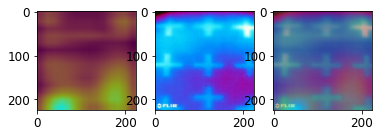

In [28]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)